In [1]:
import re
import nltk
import string
import spacy

import numpy as np 
import pandas as pd
from spacy import displacy

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.metrics import Precision, Recall
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import Attention
from keras.layers import Concatenate, Dense, Input
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer

from keras import Model
from keras.layers import Layer
from keras.utils import plot_model

import keras.backend as K

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
    

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


## LSTM + Attention - Twitter Dataset Review

In [2]:
twitter_training = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", names=["_id", "game", "sentiment", "text"])
twitter_validation = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", names=["_id", "game", "sentiment", "text"])

In [3]:
twitter_original = twitter_training.copy()
twitter_training.head(10)

,_id,game,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


<AxesSubplot:title={'center':'Number for each game in Twitter dataset'}>

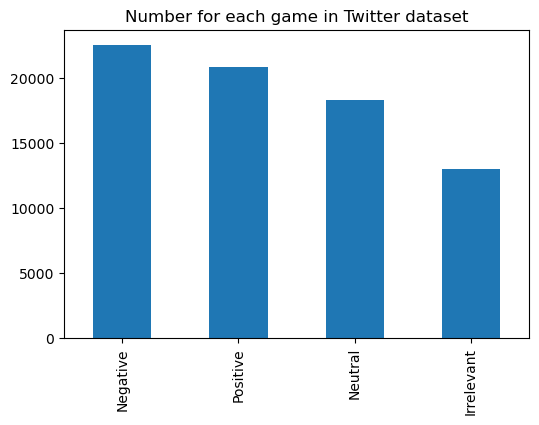

In [4]:
twitter_training["sentiment"].value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Number for each game in Twitter dataset")

<AxesSubplot:title={'center':'Number for each game in Twitter dataset'}>

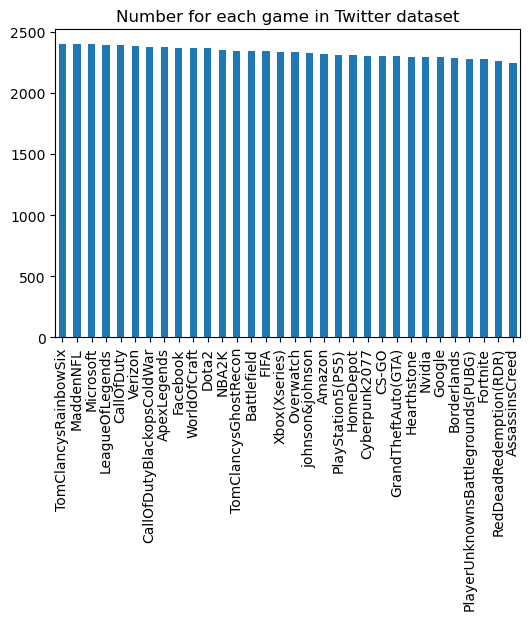

In [5]:
twitter_training["game"].value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Number for each game in Twitter dataset")

## Preprocessing

### Normalization

Normalization refers to the process of transforming data into a standard format in order to facilitate data comparison and analysis. In the context of natural language processing (NLP), normalization typically refers to the process of converting text data into a standard format. Normalization techniques in NLP include several processes such as converting text to lowercase, removing stop words, stemming, and lemmatization. The objective of normalization is to reduce the variability of text data, so that it can be more easily compared and analyzed.

Converting text to lowercase is a basic normalization technique that involves converting all the letters in a piece of text to lowercase. This is useful because it reduces the number of variations of the same word that may occur in a text corpus. For example, "Dog", "DOG", and "dog" would all be converted to "dog". Removing stop words is another common normalization technique, which involves removing common words such as "the", "a", and "an". These words do not add significant meaning to a sentence and removing them helps to reduce the dimensionality of the data.

Stemming and lemmatization are two other common normalization techniques in NLP. Stemming involves reducing words to their root form, while lemmatization involves reducing words to their base form. These techniques help to reduce the variability of words that can occur in a text corpus, making it easier to compare and analyze the data. Normalization is an important step in the preprocessing stage of NLP, as it can significantly improve the accuracy and performance of machine learning models that use text data. By reducing the variability of text data, normalization techniques help to improve the accuracy of text classification, sentiment analysis, and other NLP tasks.

<img src="https://devopedia.org/images/article/293/1027.1608556695.png">

### StopWords

Stopwords refer to the most commonly used words in a language that are considered to have little or no contribution to the meaning of a text. These words are usually removed from the text during the preprocessing stage of natural language processing (NLP) in order to improve the efficiency and accuracy of text analysis. Examples of stopwords in English include words like "the", "and", "of", "in", "to", "that", "is", "it", and so on. These words are so commonly used in English that they do not carry much semantic meaning, and their inclusion in text analysis can sometimes lead to noisy or misleading results.

Removing stopwords can help to reduce the dimensionality of text data and improve the accuracy of text analysis. This is particularly important for tasks like text classification, sentiment analysis, and topic modeling, where the focus is on identifying meaningful patterns and relationships in the text. However, it is important to note that the selection of stopwords can vary depending on the specific task or domain being analyzed. For example, certain domain-specific terms or jargon may be considered stopwords in one context but not in another. Therefore, it is often necessary to customize the list of stopwords for each specific use case.

In Natural Language Processing, there are several libraries and tools available that provide pre-defined lists of stopwords for different languages, including NLTK, spaCy, and Scikit-Learn. These libraries can be used to remove stopwords from text data during the preprocessing stage, and can significantly improve the accuracy and efficiency of text analysis tasks.

### Lemmatization
Lemmatization is a technique in Natural Language Processing (NLP) used to reduce words to their base or dictionary form, known as the lemma. The goal of lemmatization is to improve the accuracy and efficiency of text processing by reducing the number of unique words that need to be processed. Lemmatization is particularly useful in applications such as information retrieval or text classification, where the focus is on the underlying meaning of the words rather than their exact form.

Lemmatization works by using a dictionary or a morphological analysis to obtain the base form of a word. For example, the lemma of the words "ran", "runs", and "running" is "run". This process takes into account the context and part of speech of the word, so that the resulting lemma is a valid word in the language.

One of the advantages of lemmatization over stemming is that it produces a valid word in the language, which can improve the accuracy of text processing and analysis. However, lemmatization can be more computationally expensive than stemming, as it requires access to a dictionary or morphological analyzer.

Lemmatization is commonly used in applications such as information retrieval, text classification, and sentiment analysis. It can also be combined with other NLP techniques, such as part-of-speech tagging, to further improve the accuracy of text processing and analysis.

In summary, lemmatization is a valuable technique in NLP for reducing the number of unique words that need to be processed, improving the accuracy of text processing and analysis. It works by using a dictionary or morphological analysis to obtain the base form of a word, taking into account the context and part of speech of the word. While it can be more computationally expensive than stemming, it produces a valid word in the language, which can improve the accuracy of text processing and analysis.

### Stemming
Stemming is a technique in Natural Language Processing (NLP) used to reduce words to their base or root form, known as the stem. The goal of stemming is to improve the efficiency and accuracy of text processing by reducing the number of unique words that need to be processed. Stemming is particularly useful in applications such as search engines or sentiment analysis, where the focus is on the underlying meaning of the words rather than their exact form.

Stemming works by removing the suffixes from words to obtain the root form. For example, the stem of the words "running", "runs", and "run" is "run". This process can be done using a variety of algorithms, including the Porter stemming algorithm, the Snowball stemming algorithm, and the Lancaster stemming algorithm, among others.

One of the challenges of stemming is that it can sometimes result in the stem being a non-word, meaning a word that is not found in the dictionary. For example, the stem of the word "better" using the Porter stemming algorithm is "bet", which is not a word. This can sometimes lead to errors in text processing and analysis. To mitigate this, techniques such as lemmatization can be used instead of stemming, which involves reducing words to their dictionary form instead of just the stem.

Despite these challenges, stemming remains a valuable technique in NLP for reducing the number of unique words that need to be processed, thus improving the efficiency and accuracy of text processing. It is commonly used in search engines, text classification, and sentiment analysis, among other applications. However, it is important to carefully consider the specific algorithm and parameters used for stemming, as well as any potential limitations or drawbacks of the technique.

<img src="https://d2mk45aasx86xg.cloudfront.net/difference_between_Stemming_and_lemmatization_8_11zon_452539721d.webp">

In [6]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text) # Remove special char
    text = re.sub(r'<.*?>', '', text) # Remove html tags
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    text = ' '.join(tokens)
    
    return text

twitter_training['text'] = twitter_training['text'].astype(str)
twitter_validation['text'] = twitter_validation['text'].astype(str)
twitter_training['text'] = twitter_training['text'].apply(normalize_text)
twitter_validation['text'] = twitter_validation['text'].apply(normalize_text)

In [7]:
twitter_training.head(10)

,_id,game,sentiment,text
0,2401,Borderlands,Positive,im get borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,im get borderland kill
3,2401,Borderlands,Positive,im come borderland murder
4,2401,Borderlands,Positive,im get borderland murder
5,2401,Borderlands,Positive,im get borderland murder
6,2402,Borderlands,Positive,spent hour make someth fun dont know huge bord...
7,2402,Borderlands,Positive,spent coupl hour someth fun dont know im huge ...
8,2402,Borderlands,Positive,spent hour someth fun dont know im huge border...
9,2402,Borderlands,Positive,spent hour make someth fun dont know huge rhan...


In [8]:
twitter_training = twitter_training[(twitter_training["sentiment"] == "Positive") | 
                                    (twitter_training["sentiment"] == "Negative")]
twitter_validation = twitter_validation[(twitter_validation["sentiment"] == "Positive") | 
                                    (twitter_validation["sentiment"] == "Negative")]

In [9]:
sample_original = twitter_original["text"][20]
sample_original

'that was the first borderlands session in a long time where i actually had a really satisfying combat experience. i got some really good kills'

In [10]:
twitter_training["sentiment"].replace("Positive", 1, inplace=True)
twitter_training["sentiment"].replace("Negative", 0, inplace=True)
twitter_validation["sentiment"].replace("Positive", 1, inplace=True)
twitter_validation["sentiment"].replace("Negative", 0, inplace=True)

twitter_training.head(10)

,_id,game,sentiment,text
0,2401,Borderlands,1,im get borderland murder
1,2401,Borderlands,1,come border kill
2,2401,Borderlands,1,im get borderland kill
3,2401,Borderlands,1,im come borderland murder
4,2401,Borderlands,1,im get borderland murder
5,2401,Borderlands,1,im get borderland murder
6,2402,Borderlands,1,spent hour make someth fun dont know huge bord...
7,2402,Borderlands,1,spent coupl hour someth fun dont know im huge ...
8,2402,Borderlands,1,spent hour someth fun dont know im huge border...
9,2402,Borderlands,1,spent hour make someth fun dont know huge rhan...


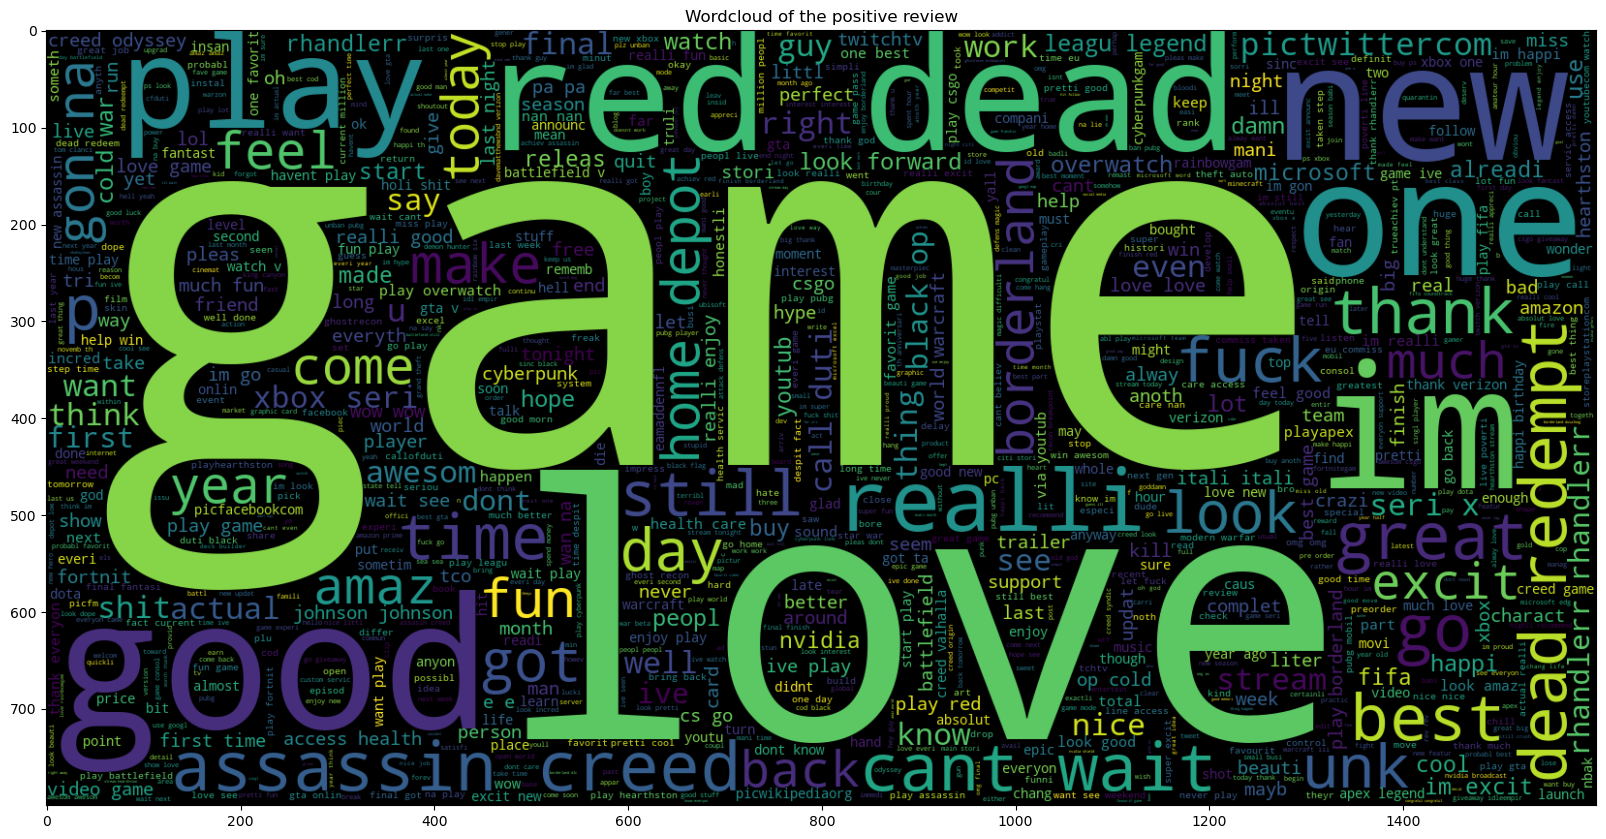

In [11]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(twitter_training[twitter_training["sentiment"] == 1]["text"]))
plt.title("Wordcloud of the positive review")
plt.imshow(wc, interpolation = 'bilinear')

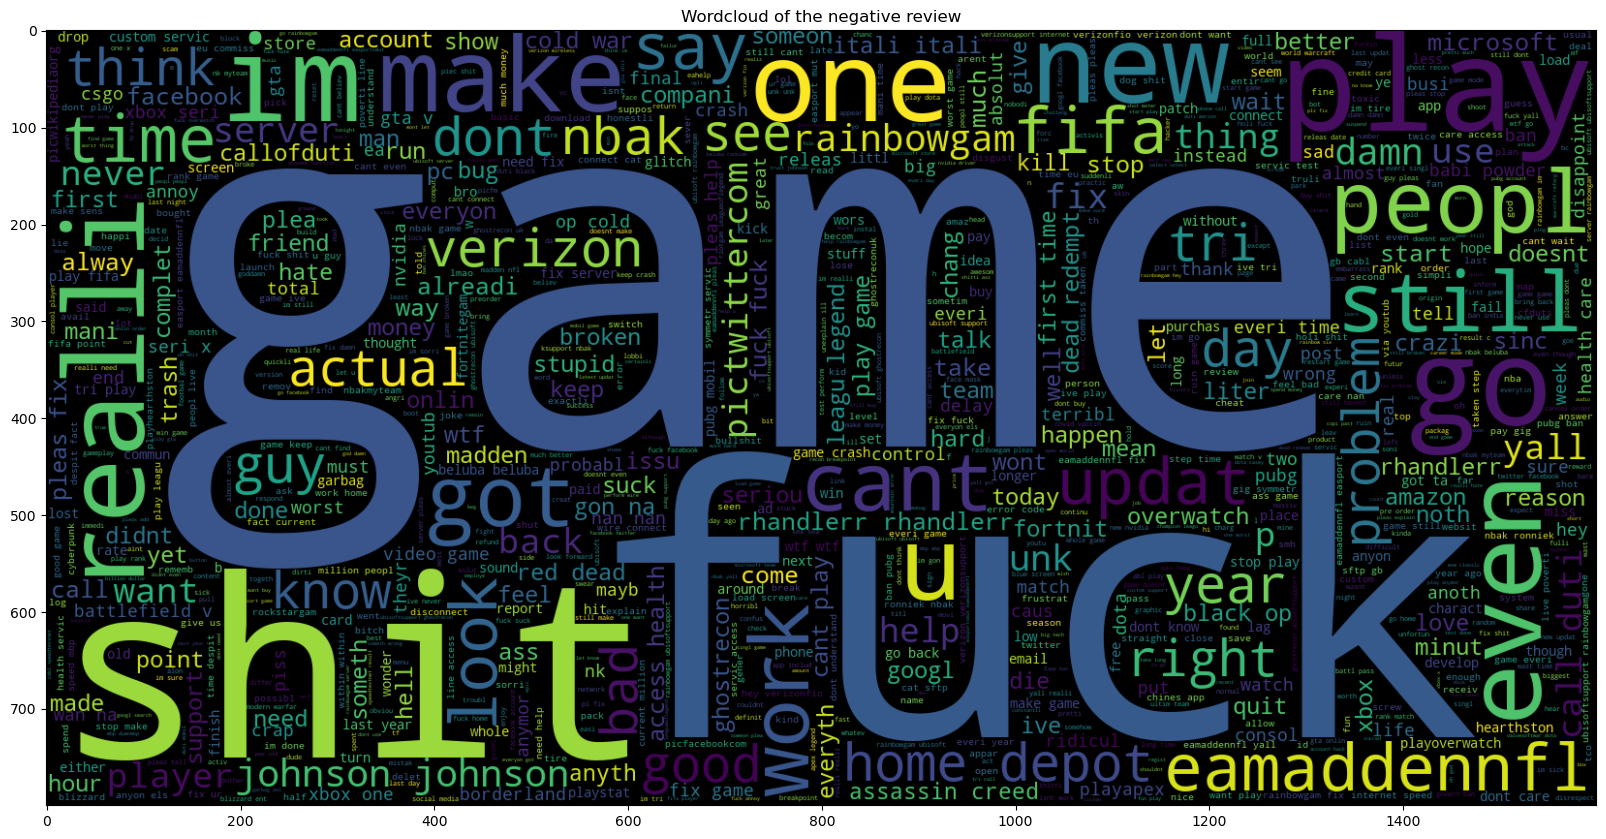

In [12]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(twitter_training[twitter_training["sentiment"] == 0]["text"]))
plt.title("Wordcloud of the negative review")
plt.imshow(wc, interpolation = 'bilinear')

## Tokenization

Tokenization is a fundamental process in Natural Language Processing (NLP) that involves segmenting text into discrete units called tokens. The goal of tokenization is to break down the text into smaller, meaningful units that can be further processed by NLP algorithms. Tokens are typically words, but they can also be phrases, sentences, or even individual characters, depending on the level of granularity required for a particular application.

There are several different approaches to tokenization, depending on the specific requirements of the task at hand. One common method is to split text into tokens based on whitespace or punctuation. This approach works well for many applications, but it can be problematic for languages that don't use spaces to separate words (e.g. Chinese or Japanese).

Another approach to tokenization is to use natural language processing techniques to identify the boundaries between words. This can be done using machine learning algorithms, such as Hidden Markov Models or Conditional Random Fields, which are trained to recognize patterns in text that indicate the presence of words or other linguistic units. This approach is more accurate than simple whitespace or punctuation-based tokenization, but it requires more computational resources and may not be suitable for all applications.

Once text has been tokenized, the resulting tokens can be further processed by NLP algorithms for tasks such as part-of-speech tagging, named entity recognition, or sentiment analysis. Tokenization is a critical first step in these tasks, as the accuracy of subsequent NLP processing depends on the quality of the initial tokenization. As such, it is important to choose a tokenization approach that is appropriate for the specific task and language being processed.

In [13]:
def fit_transform(tokenizer, text):
    return pad_sequences(tokenizer.texts_to_sequences(text), padding='post', maxlen=max_len)


max_len, max_features = 628, 1000
tokenizer = Tokenizer(num_words=max_features, split=" ")
tokenizer.fit_on_texts(twitter_training["text"])
X = fit_transform(tokenizer, twitter_training["text"])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, twitter_training["sentiment"], random_state=42, stratify=twitter_training["sentiment"], test_size=0.2)

In [15]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (34699, 628)
Test shape: (8675, 628)


## The NLP Model
### LSTM (Long Short-Term Memory)

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is capable of processing and remembering sequential data for an extended period. Unlike traditional RNNs, LSTM networks can overcome the vanishing gradient problem by using gated cells to regulate the flow of information through the network. LSTM cells have three main components: the input gate, the forget gate, and the output gate. The input gate controls the flow of new information into the cell, while the forget gate controls the retention of old information. The output gate controls the output of the cell based on the input and the current state. 

LSTM networks are widely used in natural language processing tasks, such as text classification, machine translation, and speech recognition, where sequential data needs to be processed and interpreted. They have also been successfully applied in various other fields, including image captioning, video analysis, and financial forecasting. Training an LSTM network requires a large amount of data and computation resources. However, once trained, the model can make accurate predictions on new input data, making it a powerful tool for many applications.

### Embedding Layer

An embedding layer is a fundamental component of deep learning models used for natural language processing tasks. It transforms text data into numerical vectors that can be fed into a neural network for further processing. The goal of the embedding layer is to represent each word in a way that captures its semantic meaning and context within a given text.

The embedding layer takes an input of words or sentences, which are represented as one-hot encoded vectors. Each unique word in the input vocabulary is assigned a unique vector, and all other vectors are set to zero. The embedding layer then maps these one-hot vectors to a dense vector space, where similar words are located close together, and dissimilar words are farther apart. The embedding layer can be trained on large datasets to learn the optimal mapping of words to vectors. During training, the neural network adjusts the embedding weights to minimize the loss function, which measures the difference between the predicted and actual outputs.

<img src="https://storage.googleapis.com/coderzcolumn/static/tutorials/artificial_intelligence/word_embeddings.jpg">

### Bidirectional LSTM

A bidirectional LSTM is a type of recurrent neural network that is capable of processing sequential data in both forward and backward directions. This layer has become a popular choice for natural language processing and speech recognition tasks due to its ability to capture the context of a sequence from both directions. The bidirectional LSTM layer consists of two separate LSTM networks, one running in the forward direction and one in the backward direction. The output from each network is concatenated to form the final output of the layer. This allows the network to consider both past and future context when making predictions.

During training, the bidirectional LSTM layer adjusts the weights of both the forward and backward networks to minimize the loss function, which measures the difference between the predicted and actual outputs. Bidirectional LSTM layers are commonly used in tasks such as sentiment analysis, named entity recognition, and machine translation, where the context of a sequence is critical for accurate predictions. They have been shown to improve the performance of neural networks by capturing long-term dependencies and contextual information in sequential data.

<img src="https://www.researchgate.net/publication/344751031/figure/fig2/AS:948365760155651@1603119425682/The-unfolded-architecture-of-Bidirectional-LSTM-BiLSTM-with-three-consecutive-steps.png">

### Attention Layer

An attention layer is a component of deep learning models that is used to focus on specific parts of an input sequence during processing. It has become a popular technique for natural language processing tasks, such as machine translation and text classification, where the context of a sequence is critical for accurate predictions. The attention layer takes as input a sequence of vectors and learns to assign weights to each vector based on its importance to the final output. These weights are determined by a set of learned parameters that are optimized during training. The output of the attention layer is a weighted sum of the input vectors, where the weights are determined by the learned parameters.

There are several types of attention layers, including additive attention, multiplicative attention, and self-attention. Additive attention uses a feedforward neural network to compute the weights, while multiplicative attention uses a dot product between the input and a learned weight matrix. Self-attention, also known as transformer attention, uses the input sequence itself to compute the weights and has become a popular choice for natural language processing tasks. The attention layer can be used to improve the performance of neural networks by allowing them to focus on the most important parts of an input sequence. It has been shown to be effective in tasks such as machine translation, where it can learn to align the input and output sequences, and text classification, where it can identify the most informative parts of a sentence.

However, attention layers can be computationally expensive and may require a large amount of training data to learn the optimal weights. Additionally, they may not be suitable for all types of sequential data, such as time series data where the order of the input is critical.

<img src="https://blog.floydhub.com/content/images/2019/09/Slide36.JPG">

In [16]:

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)   
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    
def lstm_model(input_len, max_features=10000, embed_size=128):
    input_layer = Input(shape=(input_len,), dtype="int32")
    embedded_layer = Embedding(max_features, embed_size)(input_layer)
    lstm_layer = Bidirectional(LSTM(64, return_sequences = True))(embedded_layer)
    attention_layer = attention()(lstm_layer)
    output_layer = Dense(1, activation='sigmoid')(attention_layer)
    
    model = Model(input_layer, output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3),
                  metrics=['accuracy', Precision(), Recall()])
    return model

In [17]:
model = lstm_model(input_len=628, max_features=10000, embed_size=128)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 628)]             0         
                                                                 
 embedding (Embedding)       (None, 628, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 628, 128)         98816     
 l)                                                              
                                                                 
 attention (attention)       (None, 128)               756       
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,379,701
Trainable params: 1,379,701
Non-trainable params: 0
___________________________________________________

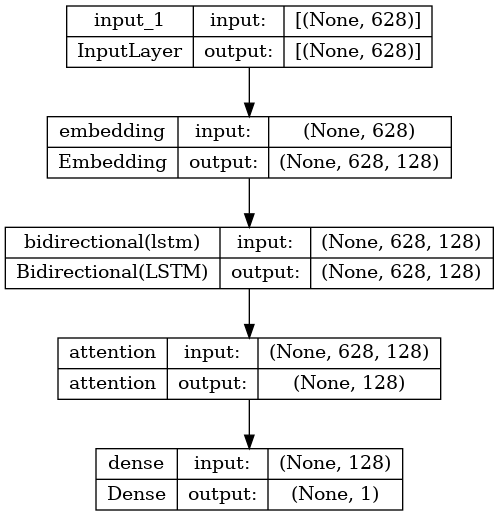

In [18]:
plot_model(model, to_file="model.png", show_shapes=True)

In [19]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1)

In [20]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                                      verbose=1, callbacks=[early_stopping])

Epoch 1/20
1085/1085 [==============================] - 54s 40ms/step - loss: 0.5925 - accuracy: 0.6678 - precision: 0.6976 - recall: 0.5443
Epoch 2/20
1085/1085 [==============================] - 43s 40ms/step - loss: 0.4660 - accuracy: 0.7889 - precision: 0.7959 - recall: 0.7536
Epoch 3/20
1085/1085 [==============================] - 43s 40ms/step - loss: 0.4449 - accuracy: 0.8118 - precision: 0.8187 - recall: 0.7811
Epoch 4/20
1085/1085 [==============================] - 44s 40ms/step - loss: 0.4060 - accuracy: 0.8189 - precision: 0.8256 - recall: 0.7899
Epoch 5/20
1085/1085 [==============================] - 43s 40ms/step - loss: 0.3571 - accuracy: 0.8405 - precision: 0.8405 - recall: 0.8243
Epoch 6/20
1085/1085 [==============================] - 43s 40ms/step - loss: 0.3445 - accuracy: 0.8488 - precision: 0.8675 - recall: 0.8088
Epoch 7/20
1085/1085 [==============================] - 44s 40ms/step - loss: 0.3263 - accuracy: 0.8582 - precision: 0.8763 - recall: 0.8205
Epoch 8/20
10

<Figure size 640x480 with 0 Axes>

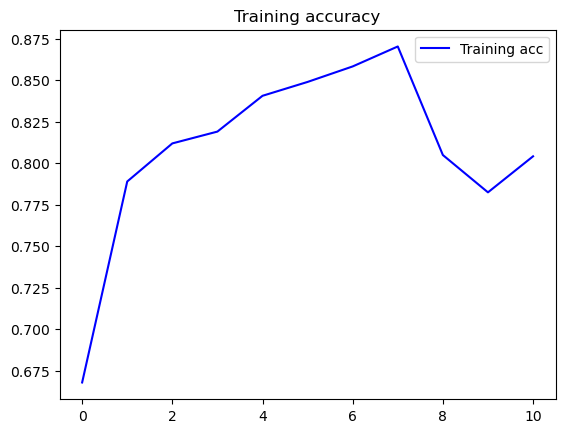

<Figure size 640x480 with 0 Axes>

In [21]:
history_ = history.history
acc, loss = history_["accuracy"], history_["loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
 
plt.figure()

<Figure size 640x480 with 0 Axes>

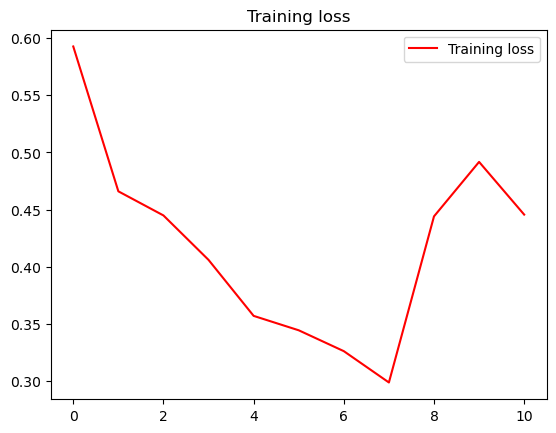

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()
 
plt.figure()

In [23]:
X_samples_val = twitter_validation["text"]
y_samples_val = twitter_validation["sentiment"]

In [24]:
def get_predict(model, tokenizer, sample):
    m_proba = model.predict(fit_transform(tokenizer, [sample]))[0][0]
    if m_proba >= 0.5:
        return {"Target": 1, "Name": "Positive"}
    return {"Target": 0, "Name": "Negative"}


def get_val_pred(index):
    print(get_predict(model, tokenizer, X_samples_val.loc[index]), f"-> Real: {y_samples_val.loc[index]}")

In [25]:
get_val_pred(40)
get_val_pred(54)
get_val_pred(19)
get_val_pred(14)

1/1 [==============================] - 1s 742ms/step
{'Target': 1, 'Name': 'Positive'} -> Real: 1
1/1 [==============================] - 0s 30ms/step
{'Target': 1, 'Name': 'Positive'} -> Real: 1
1/1 [==============================] - 0s 30ms/step
{'Target': 0, 'Name': 'Negative'} -> Real: 0
1/1 [==============================] - 0s 32ms/step
{'Target': 0, 'Name': 'Negative'} -> Real: 0


In [26]:
nlp = spacy.load('en_core_web_sm')

In [27]:
my_text_sample = "This game is very horrible. It's really bad to game"
document = nlp(my_text_sample)
displacy.render(document, style='dep', jupyter=True)

In [28]:
get_predict(model, tokenizer, normalize_text(my_text_sample))

1/1 [==============================] - 0s 30ms/step


{'Target': 0, 'Name': 'Negative'}

In [29]:
my_text_sample = "I am loving this game. each new level of the game is incredible"
get_predict(model, tokenizer, normalize_text(my_text_sample))

1/1 [==============================] - 0s 31ms/step


{'Target': 1, 'Name': 'Positive'}

In [30]:
my_text_sample = "Really amazing! I was waiting for the preview and I fell in love with each character and the whole story of the game"
get_predict(model, tokenizer, normalize_text(my_text_sample))

1/1 [==============================] - 0s 31ms/step


{'Target': 1, 'Name': 'Positive'}